Semantic Segmentation using torchvision

We will look at two Deep Learning based models for Semantic Segmentation – **Fully Convolutional Network ( FCN )** and **DeepLab v3**. These models have been trained on a subset of COCO Train 2017 dataset which corresponds to the PASCAL VOC dataset. There are a total of 20 categories supported by the models.

Input and Output

These models expect a 3-channel image (RGB) which is normalized with the Imagenet mean and standard deviation, i.e.
mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]

So, the input dimension is [Ni x Ci x Hi x Wi]
where,

Ni -> the batch size

Ci -> the number of channels (which is 3)

Hi -> the height of the image

Wi -> the width of the image

And the output dimension of the model is [No x Co x Ho x Wo]
where,

No -> is the batch size (same as Ni)

Co -> is the number of classes that the dataset have!

Ho -> the height of the image (which is the same as Hi in almost all cases)

Wo -> the width of the image (which is the same as Wi in almost all cases)

NOTE: The output of torchvision models is an **OrderedDict** and not a torch.Tensor.During inference .eval() mode the output, which is an OrderedDict has just one key – out. This out key holds the output and the corresponding values are in the shape of [No x Co x Ho x Wo].

In [ ]:
# FCN with Resnet-101 backbone (скачиваем модель)
from torchvision import models
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval() # загружаем модель с рассчитанными весами и переводим её в режим инференса

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth


100%|██████████| 208M/208M [00:01<00:00, 198MB/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fcn = fcn.to(device) # переносим модель на gpu
device

device(type='cuda')

2025-11-24 07:13:23 URL:https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg [182904/182904] -> "bird.png" [1]


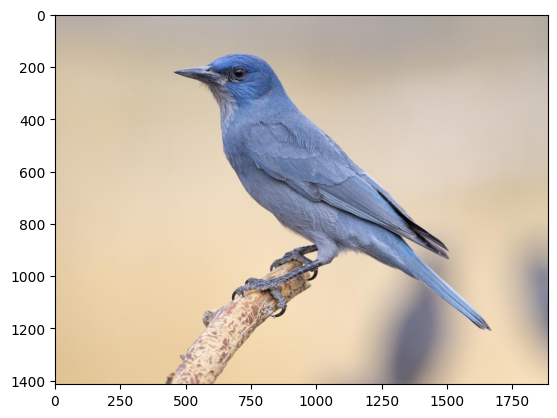

In [ ]:
# Загружаем изображение
from PIL import Image
import matplotlib.pyplot as plt # модуль для визуализации и построения графиков
import torch # основная библиотека PyTorch для работы с тензорами
!wget -nv https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg -O bird.png
img = Image.open('./bird.png')
plt.imshow(img) # передаём массив пикселей, получаем картинку

In [ ]:
# Обработка входного изображения

import torchvision.transforms as T # модуль для предобработки и аугментации изображений
# пайплайн трансформаций
trf =   T.Compose([
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(), # преобразование из PIL в torch.Tensor
        T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])
inp = trf(img).unsqueeze(0) # делаем из одного объекта (тензора) батч из одного эл-та
inp = inp.to(device)
inp.shape

torch.Size([1, 3, 224, 224])

In [ ]:
# Передаём изображение в модель (fcn)
out = fcn(inp)['out']
print (out.shape)

torch.Size([1, 21, 224, 224])


In [ ]:
# Преобразовываем в 2D изображение, где каждый пиксель принадлежит к классу
import numpy as np
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
# out.squeeze() - избавляемся от одной оси (размера батча)
# torch.argmax(, dim=0) - выбираем для каждого пикселя наиболее вероятный класс
# detach() - чтобы больше не отслеживать градиенты (мы не в режиме обучения, просто хотим работать с результатом)
# переносим тензор на cpu, чтобы можно было работать с NumPy
print (om.shape) # двумерная карта классов, где каждое значение — номер предсказанного класса для соответствующего пикселя

(224, 224)


In [ ]:
# модель обнаружила пиксели двух классов (0 - фон и 3 - птица)
print (np.unique(om))

[0 3]


In [ ]:
# 2D в rgb картинку (на выходе - цветовая маска сегментации)
def decode_segmap(image, nc=21):
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=airplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
  # создали пустые каналы rgb
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
  rgb = np.stack([r, g, b], axis=2)
  return rgb

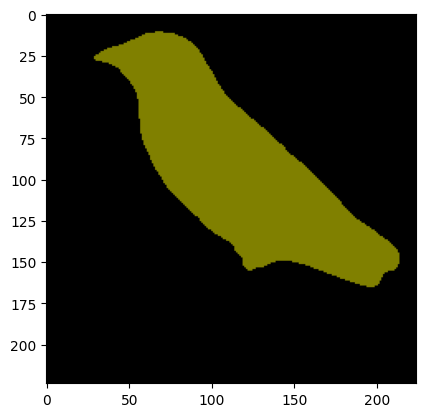

In [ ]:
rgb = decode_segmap(om)
plt.imshow(rgb)

In [ ]:
# соберём всё выше в одну функцию
def segment(net, path):
  img = Image.open(path)
  plt.imshow(img)
  plt.axis('off')
  plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([
                   #T.Resize(256),
                   #T.CenterCrop(224),
                   T.ToTensor(),
                   T.Normalize(mean = [0.485, 0.456, 0.406],
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0) # [размер батча x 3 канала x высота изображ. x ширина изображ.]
  inp = inp.to(device)
  out = net(inp)['out'] # [размер батча x 21 класс x высота изображ. x ширина изображ.]
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy() # карта классов 224*224
  print("Пиксели разделены на классы:", np.unique(om))
  rgb = decode_segmap(om) # rgb картиночка
  plt.imshow(rgb)
  plt.axis('off')

2025-11-24 07:29:28 URL:https://learnopencv.com/wp-content/uploads/2021/01/horse-segmentation.jpeg [128686/128686] -> "horse.png" [1]


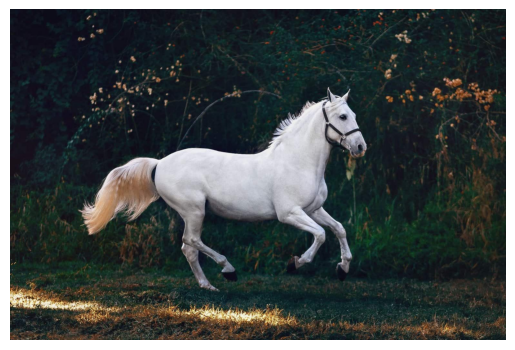

Пиксели разделены на классы: [ 0 10 12 13]


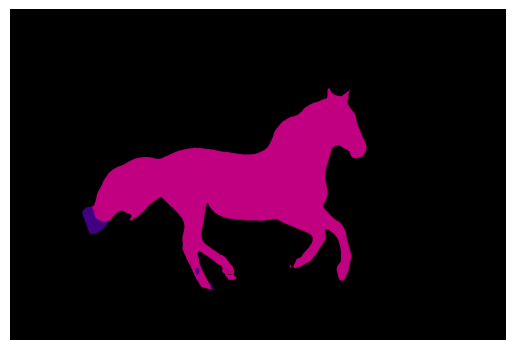

In [ ]:
!wget -nv https://learnopencv.com/wp-content/uploads/2021/01/horse-segmentation.jpeg -O horse.png
segment(fcn, './horse.png')

Собаку с коровой ещё нашёл))